In [50]:
import numpy as np
import cv2
import math
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

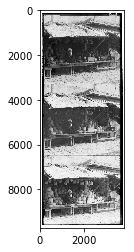

In [51]:
image= cv2 .imread('melons.tif',-1)
melons = (image >> 8).astype('uint8')
plt.imshow(melons,cmap='gray')

In [52]:
height=melons.shape[0]

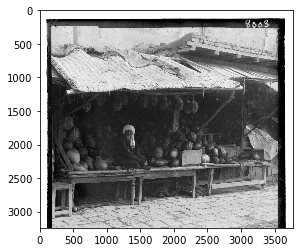

In [53]:
melon1 = melons[0:(height/3),:]
plt.imshow(melon1,cmap='gray')

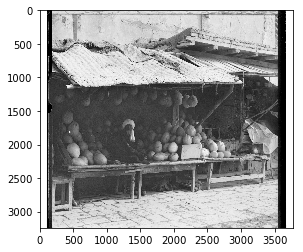

In [54]:
melon2=melons[height/3:2*(height/3),:]
plt.imshow(melon2,cmap='gray')

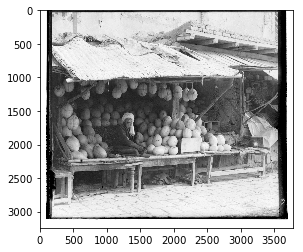

In [55]:
melon3=melons[2*(height/3):height,:]
plt.imshow(melon3,cmap='gray')

In [56]:
melon3.shape

(3242, 3770)

In [57]:
def gamma(img):
    mid = 0.5
    mean = np.mean(img)
    gamma = math.log(mid*255)/math.log(mean)

    img_gamma = np.power(img, 1).clip(0,255).astype(np.uint8)

    return img_gamma

In [58]:
B=gamma(melon1)
G=gamma(melon2)
R=gamma(melon3)

In [59]:
def sumOfSquares(a):
    return np.sum(a**2)

In [60]:
def mean(g):
    m=np.sum(g)/g.size
    return m

def ncc(g,f):
    meanG=mean(g)
    meanF=mean(f)
    s=np.sum((g-meanG)+(g-meanF))
    m=np.sum((g-meanG)**2)* np.sum((f-meanF)**0.5)
    if m!=0:
        NCC=s/m
    else :
        NCC=float('inf')
    return NCC

In [61]:
def pyramid(img1,img2,n):
    if n<1:
        shift=findShift(img1,img2,15)
    else:
        scaled1=downScale(img1,2)
        scaled2=downScale(img2,2)
        
        shift = [pyramid(scaled1, scaled2, n-1)[0]*2,pyramid(scaled1, scaled2, n-1)[1]*2]
        img2=shifted(img2,shift[0],shift[1])
        
        shift = [shift[0] + findEdgeShift(img1, img2, 5)[0],shift[1] + findEdgeShift(img1, img2, 5)[1]]
        
    return shift    

In [62]:
def ssd(img1,img2):
    t=img1-img2
    return sumOfSquares(t)

In [63]:
def findShift(A,B,t):    
    shift=[0,0]
    minimum=float('inf') 
    for x in range(-t,t):
        for y in range(-t,t):
            s=shifted(B,x,y)
            score=ncc(A,s)
            if score<minimum:
                minimum=score
                shift=[x,y]; 
            
    return shift    

In [64]:
def shifted(A,x,y):
    if x<0:
        z=np.zeros((A.shape[0],A.shape[1])).astype('int')
        z[0:x,:]=A[-x:,:]
        x_apply =z
    elif x!=0:
        z=np.zeros((A.shape[0],A.shape[1])).astype('int')
        z[x:A.shape[0],:]=A[0:-x,:]
        x_apply =z
    else:
        x_apply=A
        
    if y<0:
        z1=np.zeros((A.shape[0],A.shape[1])).astype('int')
        z1[:,0:y]=x_apply[:,-y:]
        y_apply =z1
    elif y!=0:
        z1=np.zeros((A.shape[0],A.shape[1])).astype('int')
        z1[:,y:A.shape[1]]=x_apply[:,0:-y]
        y_apply =z1
    else:
        y_apply=x_apply
        

    return y_apply

In [65]:
def findEdgeShift(A,B,t):
    minimum=float('inf')
    AEdges = cv2.Canny(A,100,200)
    shift=[0,0]
    for x in range(-t,t):
        for y in range(-t,t):
            shiftedB=shifted(B,x,y)
            array=np.uint8(shiftedB)
            shiftedB_edges=cv2.Canny(array,200,200)
            score=ssd(AEdges,shiftedB_edges)
            if score<=minimum:
                minimum=score
                shift=[x,y];
          
    return shift 

In [66]:
def downScale(img,n):
    width = int(img.shape[1]/n)
    height = int(img.shape[0]/n)
    dim = (width, height)
    e=np.uint8(img)
    resized = cv2.resize(e, dim, interpolation = cv2.INTER_AREA)
    return resized

In [67]:
#adjust size
if (R.shape[0]!=B.shape[0]):
    if R.shape[0]!=G.shape[0]:
        if R.shape[0]>G.shape[0]:
            r=R.shape[0]-1
            R=R[0:-1,:]
        else:
            g=G.shape[0]-1
            B=B[0:-1,:]
            G=G[0:-1,:]
    else:
        if B.shape[0]>G.shape[0]:
            b=B.shape[0]-1
            B=B[0:-1,:]
        else:
            r=R.shape[0]-1
            R=R[0:-1,:]
            G=G[0:-1,:]
else:
    if G.shape[0]>B.shape[0]:
            g=G.shape[0]-1
            G=G[0:-1,:]
    else:
            r=R.shape[0]-1
            R=R[0:-1,:]
            B=B[0:-1,:]  

In [68]:
shift_B=pyramid(R,B,6)
shift_G=pyramid(R,G,5)

/Users/helia_yaz/opt/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/Users/helia_yaz/opt/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


In [69]:
print(shift_B)
shiftedB=shifted(B,shift_B[0],shift_B[1])
shiftedG=shifted(G,shift_G[0],shift_G[1])

[-177, -14]


In [70]:
shift_G

[-96, -4]

In [71]:
R=np.uint8(R)
shiftedB=np.uint8(shiftedB)
shiftedG=np.uint8(shiftedG)
result=cv2.merge([R,shiftedG,shiftedB])

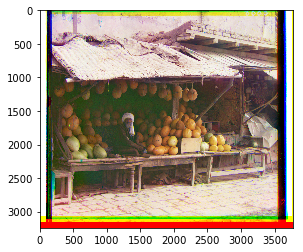

In [72]:
plt.imshow(result)

In [73]:
import scipy.misc
scipy.misc.imsave('res04.jpg',result)

/Users/helia_yaz/opt/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
